In [1]:
import tensorflow as tf
import os

# 1. Remove dodgy images

In [8]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data_dir = "data"

In [10]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [45]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

# 2. Load Data

In [46]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 480 files belonging to 2 classes.


In [52]:
data_iterator = data.as_numpy_iterator()

In [57]:
# Get another batch from the iterator
batch = data_iterator.next()

In [58]:
# Images represented batch from the iterator
batch[0].shape

(32, 256, 256, 3)

In [59]:
# Class 1 = SAD PPL (people)
# Class 0 = HAPPY PPL (people)
batch[1]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0], dtype=int32)

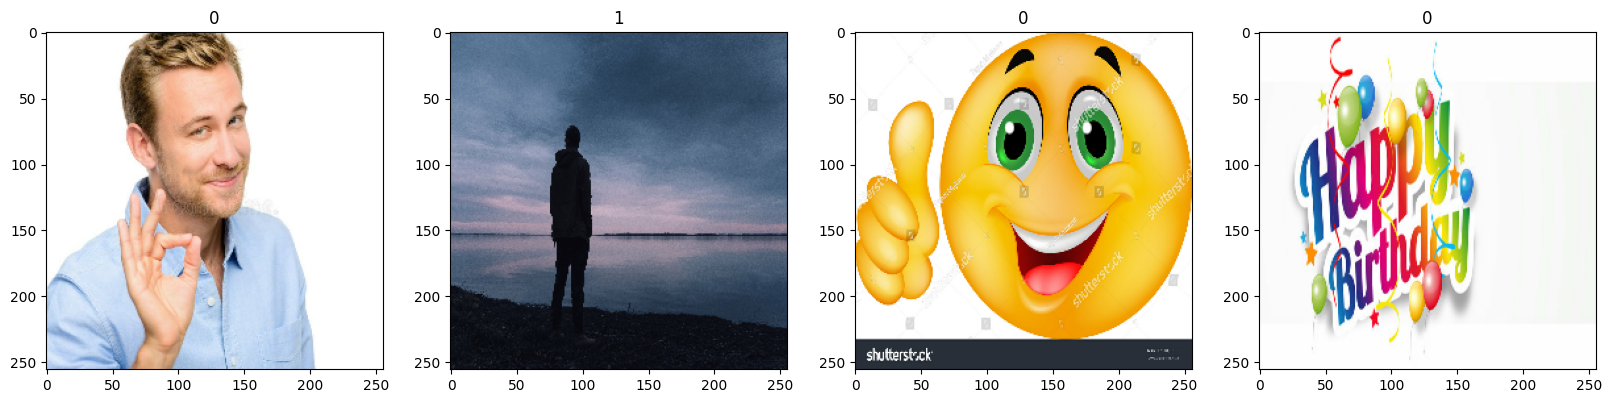

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# 3. Scale Data

In [61]:
data = data.map(lambda x,y: (x/255, y))

In [62]:
data.as_numpy_iterator().next()

(array([[[[0.12981005, 0.13765319, 0.13373162],
          [0.14748774, 0.15533088, 0.15140931],
          [0.1513174 , 0.15916054, 0.15523897],
          ...,
          [0.20033701, 0.20818014, 0.20425858],
          [0.225     , 0.23284313, 0.22892156],
          [0.13526349, 0.14310662, 0.13918506]],
 
         [[0.15481006, 0.1626532 , 0.15873162],
          [0.14800858, 0.15585172, 0.15193015],
          [0.15199143, 0.15983456, 0.155913  ],
          ...,
          [0.12772672, 0.13556986, 0.13164829],
          [0.13002451, 0.13786764, 0.13394608],
          [0.15242034, 0.16026348, 0.15634191]],
 
         [[0.16822916, 0.1760723 , 0.17215073],
          [0.17349878, 0.18134192, 0.17742035],
          [0.17120098, 0.17904411, 0.17512254],
          ...,
          [0.14332108, 0.15116422, 0.14724265],
          [0.14500612, 0.15284927, 0.1489277 ],
          [0.14175858, 0.14960171, 0.14568014]],
 
         ...,
 
         [[0.1764706 , 0.18431373, 0.18039216],
          [0.17647

# 4. Split Data

In [63]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [64]:
train_size

10

In [65]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Build Deep Learning Model

In [66]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [68]:
model = Sequential()

In [69]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\XPRISTO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Train

In [72]:
logdir='logs'

In [73]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [74]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 610ms/step - accuracy: 0.5962 - loss: 0.7933 - val_accuracy: 0.8021 - val_loss: 0.4971
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.8054 - loss: 0.5305 - val_accuracy: 0.8229 - val_loss: 0.4777
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 603ms/step - accuracy: 0.8321 - loss: 0.4094 - val_accuracy: 0.8542 - val_loss: 0.3077
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.8466 - loss: 0.3216 - val_accuracy: 0.8750 - val_loss: 0.4113
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 659ms/step - accuracy: 0.8963 - loss: 0.2874 - val_accuracy: 0.8750 - val_loss: 0.2862
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 655ms/step - accuracy: 0.8896 - loss: 0.2395 - val_accuracy: 0.8750 - val_loss: 0.3074
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 645ms/step - accuracy: 0.9063 - loss: 0.2129 - val_accuracy: 0.9062 - val_loss: 0.2343
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 0.9185 - loss: 0.1738 - val_accuracy: 0.

# 7. Plot Performance

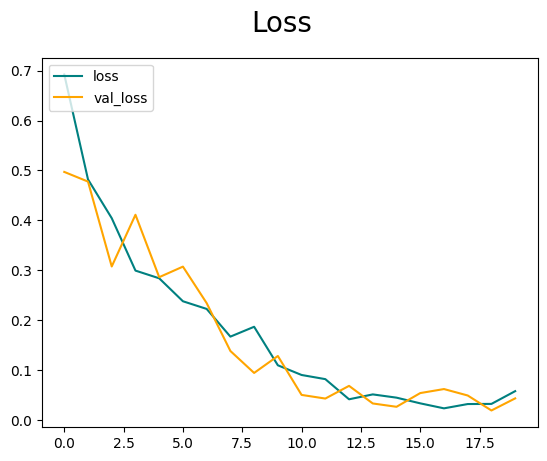

In [75]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

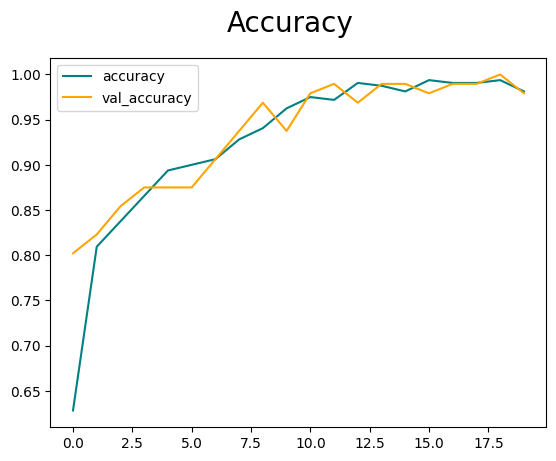

In [76]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Evaluate

In [77]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [78]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [79]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


In [80]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 9. Test

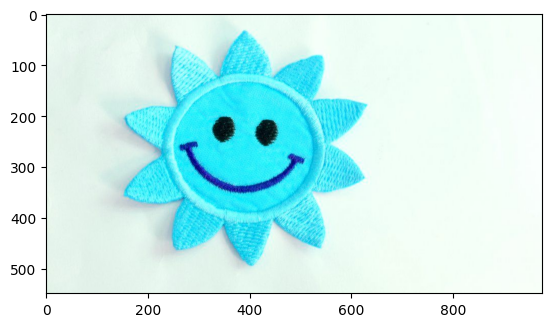

In [81]:
img = cv2.imread('_120731663_gettyimages-1057610362.jpg')
plt.imshow(img)
plt.show()

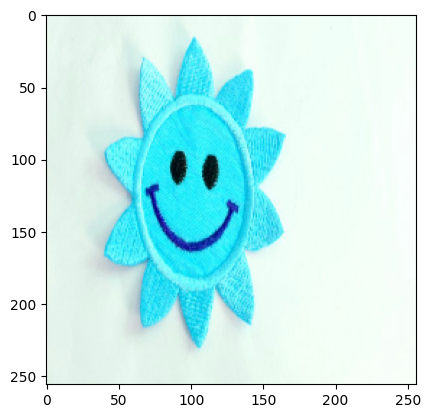

In [82]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [83]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [84]:
yhat

array([[0.04529581]], dtype=float32)

In [85]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 10. Save the Model

In [86]:
from tensorflow.keras.models import load_model

In [87]:
model.save(os.path.join('models','imageclassifier.h5'))

In [89]:
new_model = load_model('models/imageclassifier.h5')

In [90]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


array([[0.04529581]], dtype=float32)